Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 647M/658M [00:06<00:00, 198MB/s]
100% 658M/658M [00:06<00:00, 99.7MB/s]
Number of Classes: 15
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 156MB/s]


Epoch [1/10], Train Acc: 85.68%, Val Acc: 95.40%
Epoch [2/10], Train Acc: 95.42%, Val Acc: 96.49%
Epoch [3/10], Train Acc: 96.24%, Val Acc: 95.98%
Epoch [4/10], Train Acc: 96.98%, Val Acc: 96.78%
Epoch [5/10], Train Acc: 97.25%, Val Acc: 97.65%
Epoch [6/10], Train Acc: 97.80%, Val Acc: 97.70%
Epoch [7/10], Train Acc: 97.40%, Val Acc: 97.41%
Epoch [8/10], Train Acc: 98.23%, Val Acc: 97.65%
Epoch [9/10], Train Acc: 98.12%, Val Acc: 97.50%
Epoch [10/10], Train Acc: 98.70%, Val Acc: 98.18%


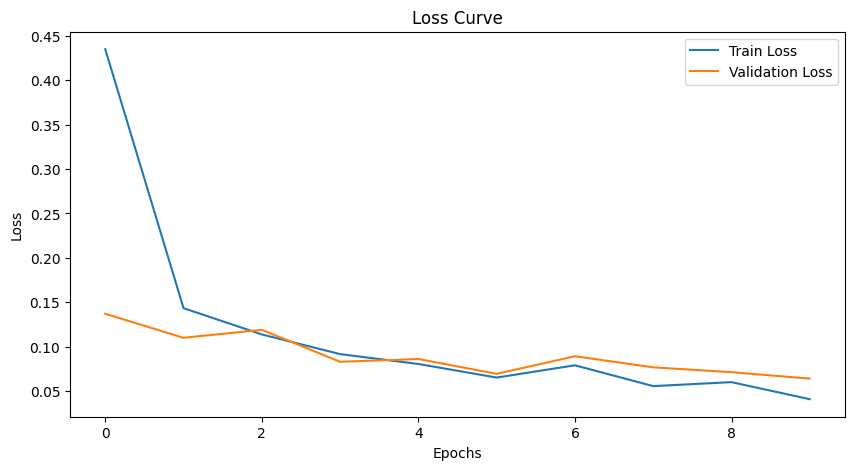


--- Model Summary ---
Training Accuracy: 98.70%
Test Accuracy: 98.06%
Training Time: 3105.34 seconds
Model Size: 106.17 MB


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny

# Step 1: Setup Kaggle API & Download Dataset
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d dataset

# Step 2: Define Paths & Data Transformations
data_dir = "dataset/PlantVillage"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Number of Classes: {num_classes}")

# Step 3: Split Dataset into Training & Validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Step 4: Define ConvNeXt Model
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = convnext_tiny(pretrained=True)
        self.model.classifier[2] = nn.Linear(768, num_classes)

    def forward(self, x):
        return self.model(x)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PlantDiseaseModel(num_classes).to(device)

# Step 5: Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Training Function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    start_time = time.time()
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation Step
        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(valid_loader))
        val_acc.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

    training_time = time.time() - start_time
    return train_acc, val_acc, train_loss, val_loss, training_time

# Step 7: Train Model
train_acc, val_acc, train_loss, val_loss, training_time = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10)

# Step 8: Plot Loss Curve
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Step 9: Model Evaluation
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total

# Step 10: Model Summary
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)  # Convert to MB
print("\n--- Model Summary ---")
print(f"Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Model Size: {model_size:.2f} MB")

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      1.00      0.98       202
                     Pepper__bell___healthy       0.98      1.00      0.99       306
                      Potato___Early_blight       1.00      1.00      1.00       184
                       Potato___Late_blight       1.00      0.85      0.92       202
                           Potato___healthy       1.00      0.75      0.86        28
                      Tomato_Bacterial_spot       0.96      1.00      0.98       409
                        Tomato_Early_blight       0.97      0.94      0.96       198
                         Tomato_Late_blight       0.92      0.98      0.95       383
                           Tomato_Leaf_Mold       1.00      1.00      1.00       220
                  Tomato_Septoria_leaf_spot       0.99      0.97      0.98       335
Tomato_Spider_mites_Two_spotted_spider_mi

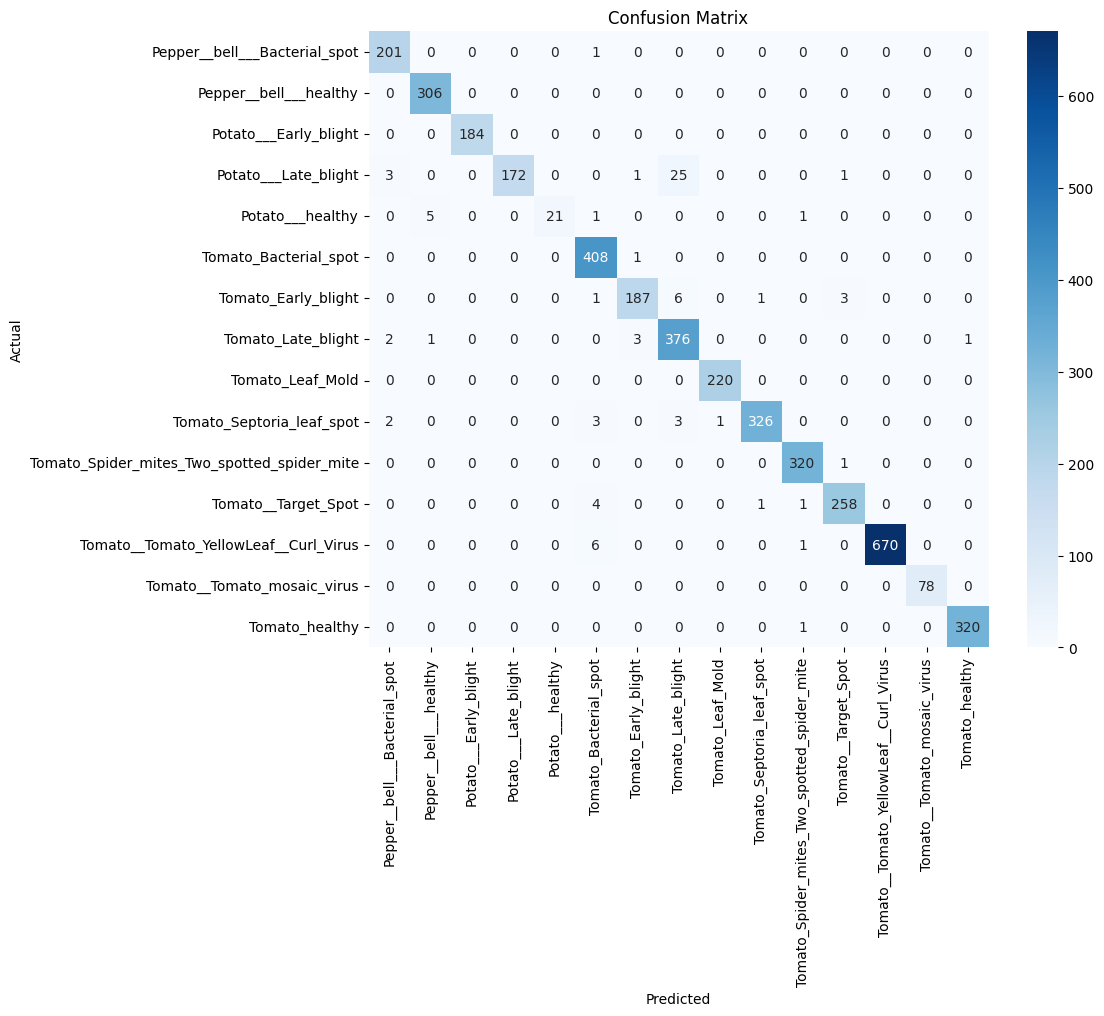


Generating AUC-ROC Curves...


<ipython-input-3-3d9ae71b2991>:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


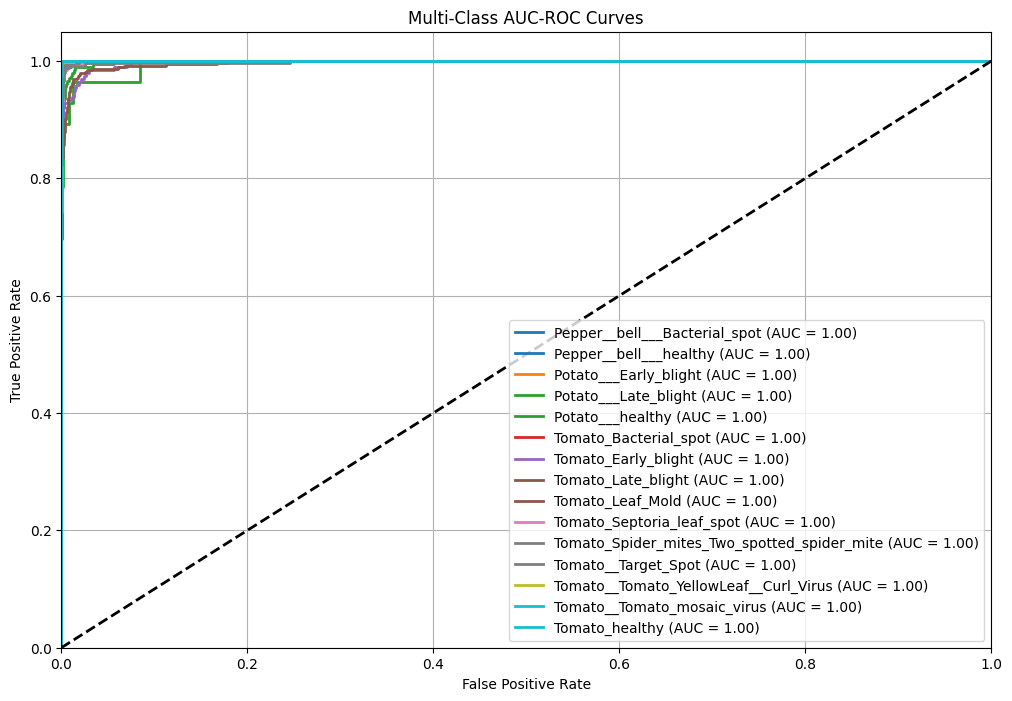

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Step 1: Model Evaluation on Validation Set
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Step 2: Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Step 3: Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 4: AUC-ROC Curve for Multi-Class
print("\nGenerating AUC-ROC Curves...")
# Binarize the labels for multi-class AUC calculation
y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', num_classes)
for i, color in zip(range(num_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class AUC-ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()